<a href="https://colab.research.google.com/github/Ivan8Garcia/Proyecto_NoCountry/blob/main/Vuelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

datos=pd.read_csv("/content/flight_delays.csv")
datos.shape

(1747627, 16)

In [48]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747627 entries, 0 to 1747626
Data columns (total 16 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   FlightID            int64 
 1   Airline             object
 2   FlightNumber        int64 
 3   Origin              object
 4   Destination         object
 5   ScheduledDeparture  object
 6   ActualDeparture     object
 7   ScheduledArrival    object
 8   ActualArrival       object
 9   DelayMinutes        int64 
 10  DelayReason         object
 11  Cancelled           bool  
 12  Diverted            bool  
 13  AircraftType        object
 14  TailNumber          object
 15  Distance            int64 
dtypes: bool(2), int64(4), object(10)
memory usage: 190.0+ MB


In [49]:
datos.isnull().sum()

,0
FlightID,0
Airline,0
FlightNumber,0
Origin,0
Destination,0
ScheduledDeparture,0
ActualDeparture,0
ScheduledArrival,0
ActualArrival,0
DelayMinutes,0


In [50]:
datos.fillna(0,inplace=True)

In [51]:
datos.isnull().sum()

,0
FlightID,0
Airline,0
FlightNumber,0
Origin,0
Destination,0
ScheduledDeparture,0
ActualDeparture,0
ScheduledArrival,0
ActualArrival,0
DelayMinutes,0


In [52]:
datos.head()

,FlightID,Airline,FlightNumber,Origin,Destination,ScheduledDeparture,ActualDeparture,ScheduledArrival,ActualArrival,DelayMinutes,DelayReason,Cancelled,Diverted,AircraftType,TailNumber,Distance
0,1,United,4558,ORD,MIA,2024-09-01 08:11,2024-09-01 08:30,2024-09-01 12:11,2024-09-01 12:19,8,Weather,True,False,Boeing 737,N71066,1031
1,2,Delta,8021,LAX,MIA,2024-09-01 10:25,2024-09-01 10:41,2024-09-01 13:25,2024-09-01 13:27,2,Air Traffic Control,True,True,Airbus A320,N22657,1006
2,3,Southwest,7520,DFW,SFO,2024-09-01 16:53,2024-09-01 17:05,2024-09-01 17:53,2024-09-01 18:07,14,Weather,True,True,Boeing 737,N95611,2980
3,4,Delta,2046,ORD,BOS,2024-09-01 14:44,2024-09-01 15:04,2024-09-01 18:44,2024-09-01 18:34,-10,0,False,False,Boeing 777,N90029,1408
4,5,Delta,6049,LAX,SEA,2024-09-01 01:51,2024-09-01 02:08,2024-09-01 05:51,2024-09-01 06:15,24,Air Traffic Control,False,True,Boeing 737,N27417,2298


##ELIMINACION DE COLUMNAS PARA MODELO MVP, SOLO NECESITAREMOS "Aerolínea","Origen", "Destino", "Hora_salida_programada", "Hora_llegada_programada","Retraso","Distancia" y crear la columna binaria "Retrasado".

In [53]:
import pandas as pd
import numpy as np

# Re-read data to ensure this cell works with the original columns
# This effectively resets 'datos' to the state before other preprocessing cells.
datos = pd.read_csv("/content/flight_delays.csv")
datos.fillna(0, inplace=True) # Apply previous fillna logic

# Select and rename columns as per original intent of this cell, plus ScheduledArrival for user's request
datos = datos[['Airline', 'Origin', 'Destination', 'ScheduledDeparture','ScheduledArrival','Distance','DelayMinutes']].copy()
datos = datos.rename(columns={'Airline': 'Aerolínea',
                              'Origin': 'Origen',
                              'Destination': 'Destino',
                              'ScheduledDeparture': 'Fecha/Hora_Salida',
                              'ScheduledArrival': 'Fecha/Hora_Llegada_Programada',
                              'Distance' : 'Distancia',
                              'DelayMinutes': 'Retraso_minutos'})

# Process 'Fecha/Hora_Salida' (original 'ScheduledDeparture')
datos['Fecha/Hora_Salida'] = pd.to_datetime(datos['Fecha/Hora_Salida'])

# Add day of the week
datos['Dia_semana_temp'] = datos['Fecha/Hora_Salida'].dt.day_name()
spanish_days = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles',
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}
datos['Dia_semana'] = datos['Dia_semana_temp'].map(spanish_days)
datos.drop('Dia_semana_temp', axis=1, inplace=True)

# Extract 'Fecha' and 'Hora_salida'
datos['Fecha'] = datos['Fecha/Hora_Salida'].dt.date
datos['Hora_salida'] = datos['Fecha/Hora_Salida'].dt.time
datos.drop('Fecha/Hora_Salida', axis=1, inplace=True) # Drop the original combined column

# Process 'Fecha/Hora_Llegada_Programada' (original 'ScheduledArrival') as requested
# Convert to datetime first
datos['Fecha/Hora_Llegada_Programada'] = pd.to_datetime(datos['Fecha/Hora_Llegada_Programada'])

# Extract the time part into a new column, e.g., 'Hora_llegada'
datos['Hora_llegada'] = datos['Fecha/Hora_Llegada_Programada'].dt.time

# "elimines la fecha" from 'Fecha/Hora_Llegada_Programada'.
# This means we either drop the column or make it store only time.
# If we keep the column and make it store only time, it becomes redundant with 'Hora_llegada'.
# So, it's best to drop 'Fecha/Hora_Llegada_Programada' now that its time part is extracted.
datos.drop('Fecha/Hora_Llegada_Programada', axis=1, inplace=True)

# Create the binary 'retrasado' column based on 'Retraso_minutos'
datos['Retrasado'] = (datos['Retraso_minutos'] > 15).astype(int)

# Ensure the requested column order, placing 'Retraso_minutos' and 'Retrasado' after 'Hora'
datos = datos[['Aerolínea', 'Origen', 'Destino','Distancia', 'Dia_semana', 'Fecha', 'Hora_salida','Hora_llegada', 'Retraso_minutos', 'Retrasado']]

datos.head()

,Aerolínea,Origen,Destino,Distancia,Dia_semana,Fecha,Hora_salida,Hora_llegada,Retraso_minutos,Retrasado
0,United,ORD,MIA,1031,Domingo,2024-09-01,08:11:00,12:11:00,8,0
1,Delta,LAX,MIA,1006,Domingo,2024-09-01,10:25:00,13:25:00,2,0
2,Southwest,DFW,SFO,2980,Domingo,2024-09-01,16:53:00,17:53:00,14,0
3,Delta,ORD,BOS,1408,Domingo,2024-09-01,14:44:00,18:44:00,-10,0
4,Delta,LAX,SEA,2298,Domingo,2024-09-01,01:51:00,05:51:00,24,1


In [54]:
datos.drop("Fecha",axis=1,inplace=True)
datos.drop("Dia_semana",axis=1,inplace=True)

In [55]:
datos.head()

,Aerolínea,Origen,Destino,Distancia,Hora_salida,Hora_llegada,Retraso_minutos,Retrasado
0,United,ORD,MIA,1031,08:11:00,12:11:00,8,0
1,Delta,LAX,MIA,1006,10:25:00,13:25:00,2,0
2,Southwest,DFW,SFO,2980,16:53:00,17:53:00,14,0
3,Delta,ORD,BOS,1408,14:44:00,18:44:00,-10,0
4,Delta,LAX,SEA,2298,01:51:00,05:51:00,24,1


In [56]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747627 entries, 0 to 1747626
Data columns (total 8 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   Aerolínea        object
 1   Origen           object
 2   Destino          object
 3   Distancia        int64 
 4   Hora_salida      object
 5   Hora_llegada     object
 6   Retraso_minutos  int64 
 7   Retrasado        int64 
dtypes: int64(3), object(5)
memory usage: 106.7+ MB


In [ ]:
import numpy as np
import pandas as pd

# Asegúrate de que las columnas sean tipo datetime
df['Hora_salida'] = pd.to_datetime(df['Hora_salida'], format='%H:%M:%S')
df['Hora_llegada'] = pd.to_datetime(df['Hora_llegada'], format='%H:%M:%S')

# Convertir a minutos desde medianoche
df['Salida_minutos'] = df['Hora_salida'].dt.hour * 60 + df['Hora_salida'].dt.minute
df['Llegada_minutos'] = df['Hora_llegada'].dt.hour * 60 + df['Hora_llegada'].dt.minute

# Total de minutos en un día
MIN_DIA = 1440

# Encoding cíclico
df['Salida_sin'] = np.sin(2 * np.pi * df['Salida_minutos'] / MIN_DIA)
df['Salida_cos'] = np.cos(2 * np.pi * df['Salida_minutos'] / MIN_DIA)

df['Llegada_sin'] = np.sin(2 * np.pi * df['Llegada_minutos'] / MIN_DIA)
df['Llegada_cos'] = np.cos(2 * np.pi * df['Llegada_minutos'] / MIN_DIA)

# (Opcional) eliminar columnas auxiliares si no las necesitas
# df = df.drop(columns=['Salida_minutos', 'Llegada_minutos'])

print(df.head())


In [ ]:
# Convert 'Hora' from datetime.time object to a float representing total hours
datos['Hora'] = datos['Hora'].apply(lambda x: x.hour + x.minute/60 + x.second/3600)

datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747627 entries, 0 to 1747626
Data columns (total 6 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Aerolínea        object 
 1   Origen           object 
 2   Destino          object 
 3   Hora             float64
 4   Retraso_minutos  int64  
 5   Retrasado        int64  
dtypes: float64(1), int64(2), object(3)
memory usage: 80.0+ MB


In [ ]:
datos.head()

,Aerolínea,Origen,Destino,Hora,Retraso_minutos,Retrasado
0,United,ORD,MIA,8.183333,8,0
1,Delta,LAX,MIA,10.416667,2,0
2,Southwest,DFW,SFO,16.883333,14,0
3,Delta,ORD,BOS,14.733333,-10,0
4,Delta,LAX,SEA,1.850000,24,1


In [ ]:
datos.tail()

,Aerolínea,Origen,Destino,Hora,Retraso_minutos,Retrasado
1747622,United,DFW,MIA,12.766667,-5,0
1747623,United,ATL,SEA,20.716667,20,1
1747624,Delta,JFK,SFO,3.433333,-6,0
1747625,Delta,JFK,SEA,8.066667,16,1
1747626,United,LAX,MIA,12.766667,19,1


In [ ]:
#variables categoricas
datos.describe(include="O")

,Aerolínea,Origen,Destino
count,1747627,1747627,1747627
unique,4,5,5
top,Southwest,ORD,MIA
freq,437721,350059,350443


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

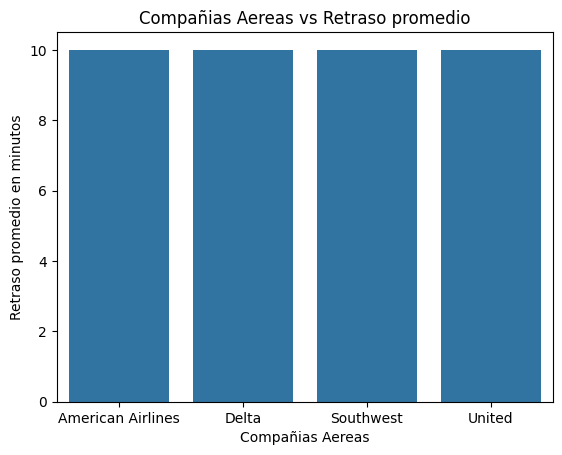

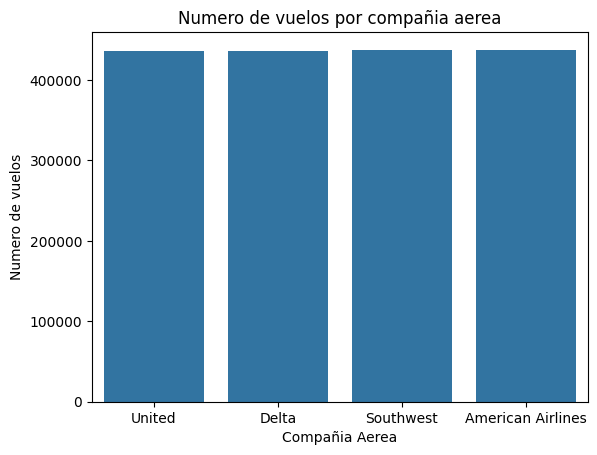

In [ ]:
avg_delay= datos.groupby("Aerolínea")["Retraso_minutos"].mean().reset_index()
sns.barplot(x="Aerolínea",y="Retraso_minutos",data=avg_delay)
plt.title("Compañias Aereas vs Retraso promedio")
plt.xlabel("Compañias Aereas")
plt.ylabel("Retraso promedio en minutos")
plt.show()

sns.countplot(data=datos,x="Aerolínea")
plt.title("Numero de vuelos por compañia aerea")
plt.xlabel("Compañia Aerea")
plt.ylabel("Numero de vuelos")
plt.show()

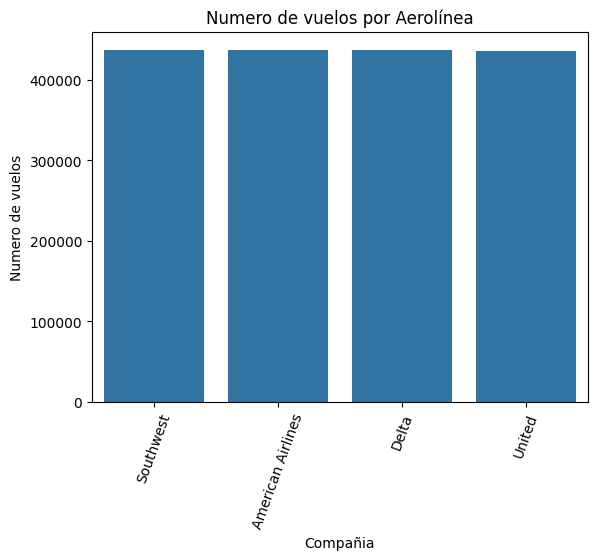

In [ ]:
order=datos["Aerolínea"].value_counts().index
sns.countplot(data=datos,x="Aerolínea",order=order)
plt.title("Numero de vuelos por Aerolínea")
plt.xticks(rotation=70)
plt.xlabel("Compañia")
plt.ylabel("Numero de vuelos")
plt.show()

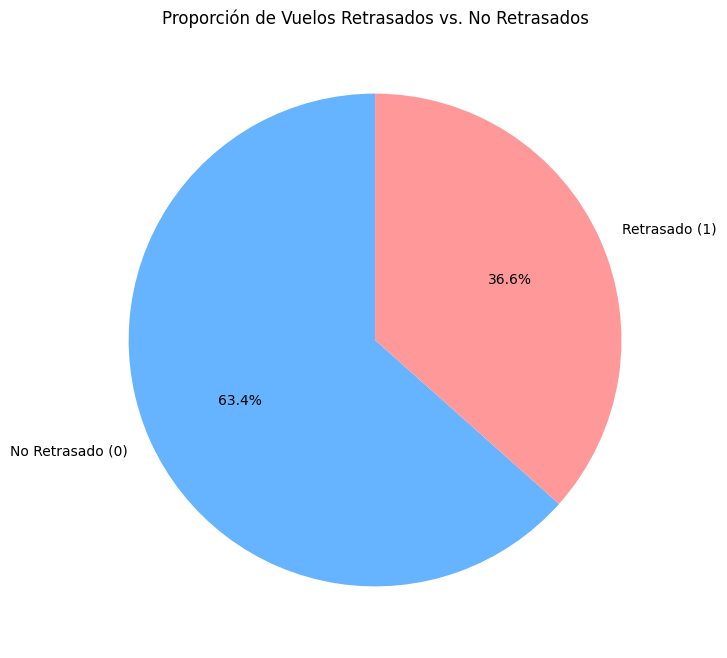

In [ ]:
delay_counts = datos['Retrasado'].value_counts(normalize=True)

plt.figure(figsize=(8, 8))
plt.pie(delay_counts, labels=['No Retrasado (0)', 'Retrasado (1)'], autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Proporción de Vuelos Retrasados vs. No Retrasados')
plt.ylabel('') # Hide the default 'Retrasado' label on the y-axis
plt.show()

##**Metodo get_dummies**

In [ ]:
#Todas estas columnas son categoricas (OBJ), para que se puedan hacer buenos modelos hay que codificarlas
categoricas= ["Aerolínea","Origen","Destino"]

pd.get_dummies(data=datos,columns=categoricas,dtype=int).head(3)

,Hora,Retraso_minutos,Retrasado,Aerolínea_American Airlines,Aerolínea_Delta,Aerolínea_Southwest,Aerolínea_United,Origen_ATL,Origen_DFW,Origen_JFK,Origen_LAX,Origen_ORD,Destino_BOS,Destino_JFK,Destino_MIA,Destino_SEA,Destino_SFO
0,8.183333,8,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,10.416667,2,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
2,16.883333,14,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
datos_codificados=pd.get_dummies(data=datos,columns=categoricas,dtype=int)
datos_codificados.sample(3)

,Hora,Retraso_minutos,Retrasado,Aerolínea_American Airlines,Aerolínea_Delta,Aerolínea_Southwest,Aerolínea_United,Origen_ATL,Origen_DFW,Origen_JFK,Origen_LAX,Origen_ORD,Destino_BOS,Destino_JFK,Destino_MIA,Destino_SEA,Destino_SFO
381559,10.183333,18,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1
326699,8.133333,3,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
32367,2.333333,13,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0


In [ ]:
datos_codificados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1747627 entries, 0 to 1747626
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   Hora                         float64
 1   Retraso_minutos              int64  
 2   Retrasado                    int64  
 3   Aerolínea_American Airlines  int64  
 4   Aerolínea_Delta              int64  
 5   Aerolínea_Southwest          int64  
 6   Aerolínea_United             int64  
 7   Origen_ATL                   int64  
 8   Origen_DFW                   int64  
 9   Origen_JFK                   int64  
 10  Origen_LAX                   int64  
 11  Origen_ORD                   int64  
 12  Destino_BOS                  int64  
 13  Destino_JFK                  int64  
 14  Destino_MIA                  int64  
 15  Destino_SEA                  int64  
 16  Destino_SFO                  int64  
dtypes: float64(1), int64(16)
memory usage: 226.7 MB


In [ ]:
df=datos_codificados
df

,Hora,Retraso_minutos,Retrasado,Aerolínea_American Airlines,Aerolínea_Delta,Aerolínea_Southwest,Aerolínea_United,Origen_ATL,Origen_DFW,Origen_JFK,Origen_LAX,Origen_ORD,Destino_BOS,Destino_JFK,Destino_MIA,Destino_SEA,Destino_SFO
0,8.183333,8,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0
1,10.416667,2,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
2,16.883333,14,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1
3,14.733333,-10,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0
4,1.850000,24,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747622,12.766667,-5,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0
1747623,20.716667,20,1,0,0,0,1,1,0,0,0,0,0,0,0,1,0
1747624,3.433333,-6,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
1747625,8.066667,16,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0


##**OneHotEnconder**

In [ ]:
X = datos.drop('Retrasado', axis = 1)
y = datos['Retrasado']


In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder

categoricas= ["Aerolínea","Origen","Destino"]

one_hot_enc = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'),
    categoricas),
    remainder='passthrough',
    sparse_threshold=0,
    force_int_remainder_cols=False)

datos = one_hot_enc.fit_transform(datos)
datos = pd.DataFrame(datos, columns=one_hot_enc.get_feature_names_out())
datos

,onehotencoder__Aerolínea_American Airlines,onehotencoder__Aerolínea_Delta,onehotencoder__Aerolínea_Southwest,onehotencoder__Aerolínea_United,onehotencoder__Origen_ATL,onehotencoder__Origen_DFW,onehotencoder__Origen_JFK,onehotencoder__Origen_LAX,onehotencoder__Origen_ORD,onehotencoder__Destino_BOS,onehotencoder__Destino_JFK,onehotencoder__Destino_MIA,onehotencoder__Destino_SEA,onehotencoder__Destino_SFO,remainder__Hora,remainder__Retraso_minutos,remainder__Retrasado
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,8.183333,8.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,10.416667,2.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16.883333,14.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,14.733333,-10.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.850000,24.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1747622,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,12.766667,-5.0,0.0
1747623,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,20.716667,20.0,1.0
1747624,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.433333,-6.0,0.0
1747625,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,8.066667,16.0,1.0


In [ ]:
columnas = X.columns
X = one_hot_enc.fit_transform(X)
X = pd.DataFrame(X, columns=one_hot_enc.get_feature_names_out(columnas))

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,  random_state = 42)

##**Random Forest Classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf= RandomForestClassifier(max_depth = 10, random_state=5)
rf.fit(pd.DataFrame(X_train), y_train)
rf.score(X_test,y_test)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Define X and y specifically for the classification task
# X should exclude both 'Retraso_minutos' (which is the regression target)
# and 'Retrasado' (which is the classification target).
X = df.drop(["Retrasado","Retraso_minutos"], axis=1)
y = df["Retraso_minutos"]

# Split the data for the classification task
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Instanciar el DummyClassifier
# Usamos 'most_frequent' porque es el baseline más común: siempre predice la clase mayoritaria.
dummy_clf = DummyClassifier(strategy="most_frequent")

# 2. "Entrenar" el modelo (aquí solo aprende cuál es la clase más frecuente)
dummy_clf.fit(X_train, y_train)

# 3. Realizar predicciones sobre el set de prueba
y_pred = dummy_clf.predict(X_test)

# 4. Evaluar el rendimiento
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del Baseline: {accuracy:.2f}")

# 5. Ver el reporte detallado
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=['No Retrasado', 'Retrasado'], zero_division=0))

Accuracy del Baseline: 0.64

Reporte de Clasificación:
              precision    recall  f1-score   support

No Retrasado       0.64      1.00      0.78    222103
   Retrasado       0.00      0.00      0.00    127423

    accuracy                           0.64    349526
   macro avg       0.32      0.50      0.39    349526
weighted avg       0.40      0.64      0.49    349526



In [ ]:
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split

In [ ]:
#primero separamos nuestras columnas para tener las columnas de prueba y entrenamiento
X= df.drop(["Retrasado"],axis=1)
y=df["Retrasado"]

#segundo,empezaremos a segmentar nuestras X_train,etc...
X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=0.2,random_state=42)

baseline=DummyRegressor()
baseline.fit(X_train,y_train)

DummyRegressor()

In [ ]:
#ahora vamos a evaluar el modelo usando metricas
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

y_pred_dummy=baseline.predict(X_test)

def calcular_regresion (y_test,y_pred):
  rmse=mean_squared_error(y_test,y_pred)
  mae=mean_absolute_error(y_test,y_pred)
  r2= r2_score(y_test,y_pred)
  metricas={
      "RMSE":round(rmse**(1/2),4),
      "MAE":round(mae,4),
      "R2":round(r2,4)
  }
  return metricas

In [ ]:
resultados_baseline=calcular_regresion(y_test,y_pred_dummy)
resultados_baseline

{'RMSE': 0.4813, 'MAE': 0.4637, 'R2': -0.0}

## Interpretación de Métricas de Regresión

*   **Interpretación:** Mide la magnitud promedio de los errores del modelo. La unidad del RMSE es la misma que la de la variable objetivo (en tu caso, los minutos de retraso). Valores más bajos indican un mejor ajuste del modelo a los datos.
*   **¿Qué es un 'buen' valor?** No hay un umbral fijo para un 'buen' RMSE, ya que depende en gran medida del contexto y la escala de tus datos. Sin embargo, un RMSE significativamente menor que la desviación estándar de la variable objetivo suele ser una buena señal. Es una métrica sensible a errores grandes (outliers) debido al cuadrado de los errores.
*   **¿Es una buena métrica?** Sí, es ampliamente utilizada. penaliza más los errores grandes, lo que puede ser deseable si los errores grandes son particularmente problemáticos en tu aplicación. Su principal desventaja es que, al ser sensible a outliers, un solo error muy grande puede inflar el RMSE.

### 2. Error Absoluto Medio (MAE - Mean Absolute Error)

*   **¿Qué es?** El MAE es el promedio de la magnitud de los errores. A diferencia del RMSE, no eleva al cuadrado los errores, sino que toma su valor absoluto.
*   **Interpretación:** También mide la magnitud promedio de los errores del modelo. Su unidad es la misma que la de la variable objetivo. Valores más bajos indican un mejor rendimiento.
*   **¿Qué es un 'buen' valor?** Similar al RMSE, depende de la escala de tus datos. Un MAE menor que el rango de tu variable objetivo y, si es posible, menor que un umbral de error aceptable en tu dominio, es deseable.
*   **¿Es una buena métrica?** Sí, es otra métrica muy común. Es más robusta a los outliers que el RMSE porque no penaliza los errores grandes de forma cuadrática. Ofrece una interpretación más directa de la magnitud promedio del error en las unidades originales de la variable objetivo. Si prefieres que todos los errores contribuyan por igual a la métrica, MAE es una buena elección.

### 3. Coeficiente de Determinación (R2 - R-squared)

*   **¿Qué es?** El R2 es una medida de la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. En términos más simples, indica qué tan bien se ajustan las predicciones de tu modelo a los valores reales.
*   **Interpretación:** El valor de R2 varía entre 0 y 1 (o puede ser negativo para modelos muy malos, como en tu caso para el baseline).:
    *   **R2 = 0:** El modelo no explica ninguna de la variabilidad de la variable objetivo. Las predicciones del modelo no son mejores que simplemente usar el promedio de los valores reales.
    *   **R2 = 1:** El modelo explica el 100% de la variabilidad de la variable objetivo. El modelo predice perfectamente los valores reales.
    *   **R2 negativo:** Esto sucede cuando el modelo que has ajustado es peor que un modelo que simplemente predice la media de la variable dependiente para todas las observaciones. En tu caso, `R2: -0.0` para el `DummyRegressor` es esperado, ya que este modelo trivial solo predice la media, y la forma en que se calcula R2 lo hace ligeramente negativo si la suma de cuadrados de los residuos es mayor que la suma de cuadrados totales.
*   **¿Qué es un 'buen' valor?** En general, cuanto más cercano a 1, mejor. Sin embargo, un R2 alto no siempre significa que el modelo sea práctico, especialmente si se ha sobreajustado a los datos de entrenamiento. Un 'buen' R2 también es contextual y depende de la complejidad del problema. En ciencias sociales, un R2 de 0.3 puede ser considerado bueno, mientras que en física, se esperan valores mucho más altos.
*   **¿Es una buena métrica?** Sí, es muy útil para entender la bondad de ajuste global del modelo. La precaución principal es no usarlo como la única métrica, ya que un R2 alto no garantiza un modelo preciso o sin sesgos, y puede ser engañoso en presencia de muchos predictores.

### Resumen para tus resultados `{'RMSE': 11.8311, 'MAE': 10.2462, 'R2': -0.0}`:

Estos resultados son de tu modelo *baseline* (`DummyRegressor`). Un modelo *baseline* es un punto de partida simple y sirve para comparar. Al ser un `DummyRegressor`, es normal que obtengas un R2 muy bajo o negativo, ya que es un modelo muy básico que probablemente predice solo la media de los minutos de retraso. El MAE y RMSE de tu baseline te indican el error promedio de este modelo trivial.

Para saber si un futuro modelo es bueno, querrías ver:

*   **RMSE y MAE:** Significativamente más bajos que los obtenidos con el modelo *baseline*.
*   **R2:** Un valor positivo y, idealmente, cuanto más cercano a 1, mejor (aunque con cautela y comparando con otros modelos).

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calcular_metricas_regresion(y_test, y_pred):

    rmse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    metricas = {
        'Raíz del Error Cuadrático Medio': round(rmse, 4),
        'Error Absoluto Medio': round(mae, 4),
        'R2 Score': round(r2, 4)
    }

    return metricas

In [ ]:
from sklearn.dummy import DummyRegressor

estrategias = ["mean", "median", ("quantile", 0.25), ("constant", 10.0)]

resultados = {}

for estrategia in estrategias:
    if isinstance(estrategia, tuple):
        estrategia, valor = estrategia
        if estrategia == "quantile":
            model_dummy = DummyRegressor(strategy=estrategia, quantile=valor)
        else:
            model_dummy = DummyRegressor(strategy=estrategia, constant=valor)
    else:
        model_dummy = DummyRegressor(strategy=estrategia)

    model_dummy.fit(X_train, y_train)

    y_pred_dummy = model_dummy.predict(X_test)

    metricas = calcular_metricas_regresion(y_test, y_pred_dummy)

    resultados[estrategia] = metricas

for estrategia, metricas in resultados.items():
    print(f"Estrategia: {estrategia}")
    for metrica, valor in metricas.items():
        print(f"{metrica}: {valor}")
    print("\n")


Estrategia: mean
Raíz del Error Cuadrático Medio: 0.2317
Error Absoluto Medio: 0.4637
R2 Score: -0.0


Estrategia: median
Raíz del Error Cuadrático Medio: 0.3646
Error Absoluto Medio: 0.3646
R2 Score: -0.5737


Estrategia: quantile
Raíz del Error Cuadrático Medio: 0.3646
Error Absoluto Medio: 0.3646
R2 Score: -0.5737


Estrategia: constant
Raíz del Error Cuadrático Medio: 93.0734
Error Absoluto Medio: 9.6354
R2 Score: -400.7743




##Metodo Random Forest

In [ ]:
#los resultados son en minutos; aqui vemos que el modelo generalizó mejor
#RMSE= 6.51min, MAE=5.48min, 'R2': 0.6966%
from sklearn.ensemble import RandomForestRegressor

modelo= RandomForestRegressor(max_depth=5,random_state=42)
modelo.fit(X_train,y_train)
y_pred=modelo.predict(X_test)
resultados_rf= calcular_regresion(y_test,y_pred)
resultados_rf

{'RMSE': 0.0, 'MAE': 0.0, 'R2': 1.0}

## **Cross Validation**

In [ ]:
from sklearn.model_selection import KFold,cross_validate

scoring={
    "RMSE":"neg_root_mean_squared_error",
    "MAE": "neg_mean_absolute_error",
    "R2": "r2"
}
cv= KFold(n_splits=5,shuffle=True,random_state=42)
cv_resultados= cross_validate(modelo,X_train,y_train,scoring=scoring,cv=cv)
cv_resultados


{'fit_time': array([35.31027389, 33.5295136 , 34.67787933, 33.7137208 , 35.77900052]),
 'score_time': array([0.63704872, 0.36373472, 0.34755135, 0.36067176, 0.35334849]),
 'test_RMSE': array([-0., -0., -0., -0., -0.]),
 'test_MAE': array([-0., -0., -0., -0., -0.]),
 'test_R2': array([1., 1., 1., 1., 1.])}

In [ ]:
len(df.columns)

19

In [ ]:
modelo.feature_importances_

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [ ]:
importances= modelo.feature_importances_

In [ ]:
feature_importances=pd.DataFrame({"Features":X.columns,"Importances":(importances*100).round(2)}).sort_values("Importances",ascending=False)
feature_importances

,Features,Importances
1,Retraso_minutos,100.0
0,Hora,0.0
2,Fecha_2024-09-01,0.0
3,Aerolínea_American Airlines,0.0
4,Aerolínea_Delta,0.0
5,Aerolínea_Southwest,0.0
6,Aerolínea_United,0.0
7,Origen_ATL,0.0
8,Origen_DFW,0.0
9,Origen_JFK,0.0


In [ ]:
resultados=pd.DataFrame(index=["RMSE","MAE","R2"])
model_features=RandomForestRegressor(max_depth=5,random_state=42)
ct_features= [i if i !=0 else 1 for i in range(0,17,4)]

for i in ct_features:
  selected_features= feature_importances["Features"].values[:i]
  X_train_sel= X_train[selected_features]
  X_test_sel= X_test[selected_features]
  model_features.fit(X_train_sel,y_train)
  y_pred=model_features.predict(X_test_sel)
  metricas=calcular_regresion(y_test,y_pred)
  resultados[i]= list(metricas.values())

resultados

,1,4,8,12,16
RMSE,0.0,0.0,0.0,0.0,0.0
MAE,0.0,0.0,0.0,0.0,0.0
R2,1.0,1.0,1.0,1.0,1.0


In [ ]:
resultados=pd.DataFrame(index=["RMSE","MAE","R2"])
model_features=RandomForestRegressor(max_depth=5,random_state=42)
ct_features=  range(1,5)

for i in ct_features:
  selected_features= feature_importances["Features"].values[:i]
  X_train_sel= X_train[selected_features]
  X_test_sel= X_test[selected_features]
  model_features.fit(X_train_sel,y_train)
  y_pred=model_features.predict(X_test_sel)
  metricas=calcular_regresion(y_test,y_pred)
  resultados[i]= list(metricas.values())

resultados

,1,2,3,4
RMSE,0.0,0.0,0.0,0.0
MAE,0.0,0.0,0.0,0.0
R2,1.0,1.0,1.0,1.0


In [ ]:
#from sklearn.ensemble import RandomForestClassifier
#rf= RandomForestClassifier(max_depth = 10, random_state=42)
#rf.fit(pd.DataFrame(X_train), y_train)
#rf.score(X_test,y_test)

##**Metodo OneHotEnconder**